# <ins>Final Project - Part 3</ins> 

## <ins>Task definition</ins> 



1.	We planted damage in our image of the type: "salt and pepper" noise.


2.	We'll train our model on the original and the damaged photos.


3.	Next, our model gets as input only damage photos and we would like to see how he fix the damages and return as a new photo, close as possible to the original image without the damages. 

## <ins>General information about the dataset</ins>  

We'll use 'Dog vs Cat' Dataset for this part of the project.

The training archive contains 25,000 images of dogs and cats. 

https://www.kaggle.com/c/dogs-vs-cats/data

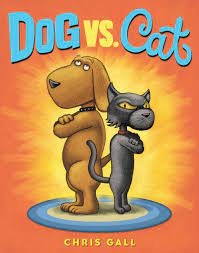

## <ins>Imports</ins> 

In [1]:
# basic imports

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# model imports

from tensorflow.keras import layers
from tensorflow.keras.models import Model

# data imports

import os
import cv2
from random import shuffle
from tqdm import tqdm
from sklearn.model_selection import train_test_split as split

## <ins>Load Dataset</ins> 

Since we only need images from the dataset to encode and decode, we won't use the labels.

In [2]:
size_ = 64

In [3]:
def label_img(img):
    word_label = img.split('.')[-3]
    
    if word_label == 'cat': 
        return 0
    
    elif word_label == 'dog': 
        return 1

def creat_data(data):
    df = []
    
    for img in tqdm(os.listdir(data)):
        label = label_img(img)
        path = os.path.join(data, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (size_, size_))
        df.append([np.array(img), np.array(label)])
        
    shuffle(df)
    np.save('df.npy', df)
    
    return df

data = r'C:/Users/moria/Desktop/project/Part 3-Dog vs Cat/data/train'

data = creat_data(data)

100%|██████████| 25000/25000 [00:23<00:00, 1062.56it/s]
C:\Users\moria\Anaconda3\envs\tensorflow\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [4]:
len(data)

25000

In [5]:
X = np.array([i[0] for i in data]).reshape(25000,4096)
Y = np.array([i[1] for i in data]).reshape(25000,1)

x_train, x_test, y_train, y_test = split(X, Y, test_size=0.3, random_state=42)

## <ins>Clean and prepare the Data</ins> 

In [6]:
def preprocess_data(array):
    # Normalizes the supplied array
    array = array.astype("float32") / 255.0
    
    # Reshapes it into the appropriate format
    array = np.reshape(array, (len(array), size_, size_, 1))
    return array


def add_noise(array):
    # Adds random noise to each image in the supplied array.
    noise_factor = 0.3
    noisy_array = array + (noise_factor * np.random.normal(loc=0.0, scale=1.0, size=array.shape))
    return np.clip(noisy_array, 0.0, 1.0)

Normalize and reshape the data

In [7]:
train_data = preprocess_data(x_train)
test_data = preprocess_data(x_test)

Create a copy of the data with added noise

In [8]:
noisy_train_data = add_noise(train_data)
noisy_test_data = add_noise(test_data)

#### Display the train data and a version of it with added noise

In [9]:
def display(arr_1, arr_2):
    n = 10
    Indexes = np.random.randint(len(arr_1), size=n)
    images1 = arr_1[Indexes, :]
    images2 = arr_2[Indexes, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(image1.reshape(size_, size_))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(image2.reshape(size_, size_))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

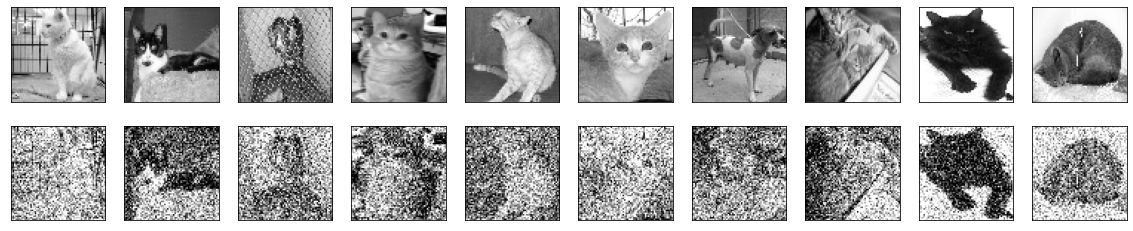

In [10]:
display(train_data, noisy_train_data)

# <ins>Auto-Encoded Model</ins> 

In [11]:
input = layers.Input(shape=(size_, size_, 1))

### Encoder

In [12]:
x = layers.Conv2D(48, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(96, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(192, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

### Decoder

In [13]:
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

### Autoencoder

In [14]:
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 48)        480       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 96)        41568     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 192)       166080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 192)        

In [15]:
train_data.shape

(17500, 64, 64, 1)

In [16]:
test_data.shape

(7500, 64, 64, 1)

## <ins>Train our model</ins>

In [17]:
autoencoder.fit(x=train_data,
                y=train_data,
                epochs=75,
                batch_size=256,
                shuffle=True,
                validation_data=(test_data, test_data))

Epoch 1/75
69/69 [==============================] - 124s 2s/step - loss: 0.6271 - val_loss: 0.5869
Epoch 2/75
69/69 [==============================] - 125s 2s/step - loss: 0.5819 - val_loss: 0.5771
Epoch 3/75
69/69 [==============================] - 126s 2s/step - loss: 0.5758 - val_loss: 0.5728
Epoch 4/75
69/69 [==============================] - 126s 2s/step - loss: 0.5735 - val_loss: 0.5714
Epoch 5/75
69/69 [==============================] - 124s 2s/step - loss: 0.5717 - val_loss: 0.5699
Epoch 6/75
69/69 [==============================] - 128s 2s/step - loss: 0.5704 - val_loss: 0.5691
Epoch 7/75
69/69 [==============================] - 130s 2s/step - loss: 0.5696 - val_loss: 0.5682
Epoch 8/75
69/69 [==============================] - 132s 2s/step - loss: 0.5688 - val_loss: 0.5671
Epoch 9/75
69/69 [==============================] - 132s 2s/step - loss: 0.5677 - val_loss: 0.5664
Epoch 10/75
69/69 [==============================] - 123s 2s/step - loss: 0.5674 - val_loss: 0.5668
Epoch 11/

#### Display the test data and predictions of it

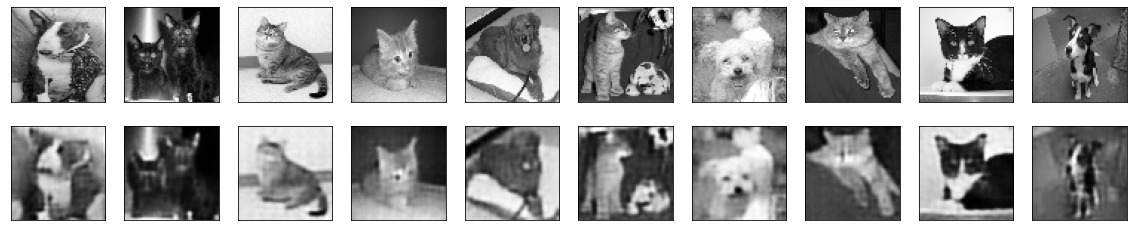

In [18]:
predictions = autoencoder.predict(test_data)

display(test_data, predictions)

## <ins>Test our model</ins>

In [19]:
history = autoencoder.fit(x=noisy_train_data,
                          y=train_data,
                          epochs=150,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(noisy_test_data, test_data))

Epoch 1/150
69/69 [==============================] - 121s 2s/step - loss: 0.6395 - val_loss: 0.5891
Epoch 2/150
69/69 [==============================] - 120s 2s/step - loss: 0.5837 - val_loss: 0.5796
Epoch 3/150
69/69 [==============================] - 120s 2s/step - loss: 0.5794 - val_loss: 0.5777
Epoch 4/150
69/69 [==============================] - 120s 2s/step - loss: 0.5780 - val_loss: 0.5767
Epoch 5/150
69/69 [==============================] - 120s 2s/step - loss: 0.5772 - val_loss: 0.5760
Epoch 6/150
69/69 [==============================] - 120s 2s/step - loss: 0.5764 - val_loss: 0.5755
Epoch 7/150
69/69 [==============================] - 121s 2s/step - loss: 0.5760 - val_loss: 0.5752
Epoch 8/150
69/69 [==============================] - 121s 2s/step - loss: 0.5756 - val_loss: 0.5747
Epoch 9/150
69/69 [==============================] - 120s 2s/step - loss: 0.5753 - val_loss: 0.5743
Epoch 10/150
69/69 [==============================] - 120s 2s/step - loss: 0.5750 - val_loss: 0.5741

69/69 [==============================] - 121s 2s/step - loss: 0.5703 - val_loss: 0.5697
Epoch 83/150
69/69 [==============================] - 122s 2s/step - loss: 0.5704 - val_loss: 0.5696
Epoch 84/150
69/69 [==============================] - 121s 2s/step - loss: 0.5703 - val_loss: 0.5697
Epoch 85/150
69/69 [==============================] - 125s 2s/step - loss: 0.5704 - val_loss: 0.5697
Epoch 86/150
69/69 [==============================] - 121s 2s/step - loss: 0.5702 - val_loss: 0.5698
Epoch 87/150
69/69 [==============================] - 120s 2s/step - loss: 0.5702 - val_loss: 0.5698
Epoch 88/150
69/69 [==============================] - 120s 2s/step - loss: 0.5703 - val_loss: 0.5699
Epoch 89/150
69/69 [==============================] - 121s 2s/step - loss: 0.5702 - val_loss: 0.5696
Epoch 90/150
69/69 [==============================] - 121s 2s/step - loss: 0.5701 - val_loss: 0.5696
Epoch 91/150
69/69 [==============================] - 121s 2s/step - loss: 0.5702 - val_loss: 0.5695
Epo

#### Display the test data and a version of it with added noise

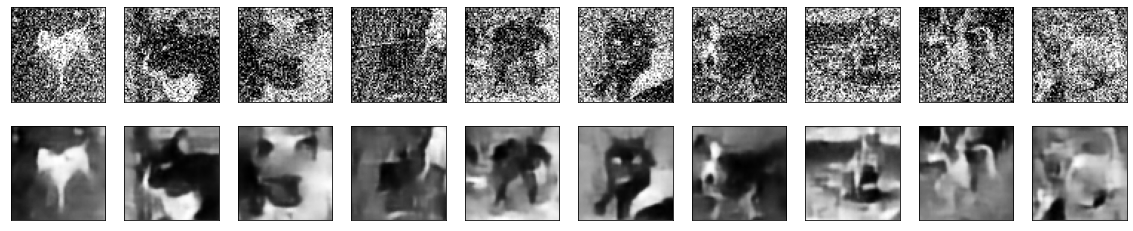

In [20]:
predictions = autoencoder.predict(noisy_test_data)

display(noisy_test_data, predictions)

## <ins>Loss function</ins>

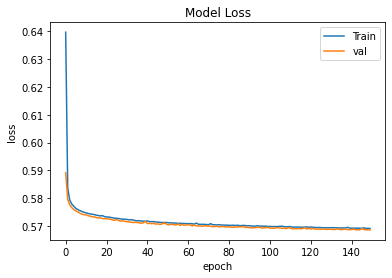

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'val'], loc='upper right')
plt.show()